In [1]:
import pyterrier as pt
import os
import numpy as np
import pandas as pd
import fastrank
import requests
import datetime

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

In [2]:
if not pt.started():
    pt.init()

PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


## Downloading the trec covid dataset

In [3]:
dataset = pt.datasets.get_dataset('irds:cord19/trec-covid')
pt_index_path = './indices/cord19'

if not os.path.exists(pt_index_path + "/data.properties"):
    indexer = pt.index.IterDictIndexer(pt_index_path, blocks=True)
    index_ref = indexer.index(dataset.get_corpus_iter(), 
                            fields=['title', 'doi', 'abstract'], 
                            meta=('docno',))
else:
    index_ref = pt.IndexRef.of(pt_index_path + "/data.properties")

In [4]:
metadata = pd.read_csv('~/.ir_datasets/cord19/2020-07-16/metadata.csv')

/var/folders/vc/33g3tqwn4c59qnzswhnf6ry00000gn/T/ipykernel_30287/1653216099.py:1: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('~/.ir_datasets/cord19/2020-07-16/metadata.csv')


In [5]:
index = pt.IndexFactory.of(index_ref)
topics = dataset.get_topics('title')
qrels = dataset.get_qrels()

In [6]:
qrels

,qid,docno,label,iteration
0,1,005b2j4b,2,4.5
1,1,00fmeepz,1,4
2,1,010vptx3,2,0.5
3,1,0194oljo,1,2.5
4,1,021q9884,1,4
...,...,...,...,...
69313,50,zvop8bxh,2,5
69314,50,zwf26o63,1,5
69315,50,zwsvlnwe,0,5
69316,50,zxr01yln,1,5


In [7]:
len(metadata['journal'].unique())

18112

### How do pipes work

We set up a two-stage ranking pipeline with a BM25 first stage ranker whose outputs will be reranked by a ML method given the predefined featues.

In [8]:
BM25 = pt.BatchRetrieve(index, controls={"wmodel": "BM25"})
TF_IDF = pt.BatchRetrieve(index, controls = {"wmodel":"TF_IDF"})
PL2 = pt.BatchRetrieve(index, controls = {"wmodel": "PL2"})

We make a pipe by transforming the BM25 outputs with the help of PL2 and TFIDF

In [9]:
pipe = BM25 >>(TF_IDF ** PL2)

Alternative: FeatureBatchRetrieve object

In [10]:
fbr = pt.FeaturesBatchRetrieve(index, controls = {"wmodel": "BM25"}, features=["WMODEL:TF_IDF", "WMODEL:PL2"]) 
(fbr % 5).search("coronavirus immunity")

,qid,query,docid,rank,features,docno,score
0,1,coronavirus immunity,187945,0,"[4.540221677858543, 3.477440707307063]",sp212tai,10.118259
1,1,coronavirus immunity,126990,1,"[4.377525236902022, 3.3080236155861185]",e1mw9lx1,10.001470
2,1,coronavirus immunity,179948,2,"[4.559628851404359, 3.5124279884117215]",ltmuw6f8,9.974369
3,1,coronavirus immunity,156456,3,"[4.600248221319108, 3.649953983552013]",1oruu33o,9.955978
4,1,coronavirus immunity,94922,4,"[4.490926556339275, 3.312256733881456]",5jl6ltfj,9.734640


### LTR

Split into train test using cross validation

In [11]:
train_topics, validation_topics, test_topics = np.split(topics, [int(.6*len(topics)), int(.8*len(topics))])

In [12]:
train_min = train_topics['qid'].astype(int).min()
train_max = train_topics['qid'].astype(int).max()
train_qrels = qrels[(qrels['qid'].astype(int) >= train_min) & (qrels['qid'].astype(int) <= train_max)]

val_min = validation_topics['qid'].astype(int).min()
val_max = validation_topics['qid'].astype(int).max()
validation_qrels = qrels[(qrels['qid'].astype(int) >= val_min) & (qrels['qid'].astype(int) <= val_max)]

test_min = test_topics['qid'].astype(int).min()
test_max = test_topics['qid'].astype(int).max()
test_qrels = qrels[(qrels['qid'].astype(int) >= test_min) & (qrels['qid'].astype(int) <= test_max)]

# How well do the algorithm work without any features?

Following, the five testes ranking algorithms will be put to the test. We are using the PL2 algorithm as a baseline and compare it to LambdaMart, LightGBM, Random Forest, FastRank with Gradient Ascent and FastRank with Random Forest.

In [13]:
pl2 = pt.BatchRetrieve(index, wmodel="PL2")
fbr = pt.FeaturesBatchRetrieve(index, controls = {"wmodel": "BM25"}, features=["WMODEL:BM25"])

In [14]:
lmart_x = xgb.sklearn.XGBRanker(objective='rank:pairwise',
      learning_rate=0.1,
      gamma= 1,
      min_child_weight=1,
      max_depth=6,
      verbose=2,
      random_state=42)

In [15]:
train_request = fastrank.TrainRequest.coordinate_ascent()
params = train_request.params
train_request.measure = 'ndcg'
params.init_random = True
params.normalize = True
params.seed = 1234567

In [16]:
train_request_forest = fastrank.TrainRequest.random_forest()
params = train_request_forest.params
train_request_forest.measure = 'ndcg'
params.num_trees = 10
params.feature_sampling_rate = 0.5
params.instance_sampling_rate = 0.5
params.seed = 1234567

In [17]:
rf = RandomForestRegressor(n_estimators= 300)
rf_pipe = fbr >> pt.ltr.apply_learned_model(rf)

In [18]:
lmart_x_pipe = fbr >> pt.ltr.apply_learned_model(lmart_x, form="ltr")
lmart_x_pipe.fit(train_topics, train_qrels, validation_topics, validation_qrels)

rf_pipe = fbr >> pt.ltr.apply_learned_model(rf)
rf_pipe.fit(train_topics, qrels)

ca_pipe = fbr >> pt.ltr.apply_learned_model(train_request, form="fastrank")
ca_pipe.fit(train_topics, qrels)

fr_rf_pipe = fbr >> pt.ltr.apply_learned_model(train_request_forest, form="fastrank")
fr_rf_pipe.fit(train_topics, qrels)

[21:26:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #2/5...
[+] Random restart #5/5...
[+] Random restart #4/5...
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
----------------------------------------
   4|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
------------------------------

In [19]:
results = pt.Experiment([PL2, BM25, lmart_x_pipe, rf_pipe, ca_pipe, fr_rf_pipe], test_topics, qrels, ["ndcg", "map"], 
                        names=["PL2 (Baseline)", "BM25 (base ranker)", "LMART", "Random Forest", "Fastrank Coordinate Ascend", "Fastrank Random Forest"], baseline = 0, filter_by_topics = True)

In [20]:
results

,name,map,ndcg,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value
0,PL2 (Baseline),0.313517,0.523699,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25 (base ranker),0.307945,0.527753,7.0,3.0,0.551904,6.0,4.0,0.461508
2,LMART,0.189992,0.448421,0.0,10.0,0.007039,1.0,9.0,0.004779
3,Random Forest,0.147439,0.421809,0.0,10.0,0.003089,1.0,9.0,0.002672
4,Fastrank Coordinate Ascend,0.283973,0.519278,1.0,9.0,0.042773,2.0,8.0,0.471011
5,Fastrank Random Forest,0.154931,0.424146,0.0,10.0,0.001263,1.0,9.0,0.000867


## Applying recency boost

In [21]:
metadata['publish_year'] = pd.to_datetime(metadata['publish_time'])
metadata['publish_year'] = metadata['publish_year'].dt.strftime('%Y')
metadata['publish_year'] = metadata['publish_year'].fillna(0)
metadata['publish_year'] = metadata['publish_year'].astype(str).astype(int)

metadata['publish_year_feature'] = 0

metadata.loc[metadata['publish_year'] < 2019, 'publish_year_feature'] = 1
metadata.loc[metadata['publish_year'] == 2019, 'publish_year_feature'] = 2
metadata.loc[metadata['publish_year'] >= 2020, 'publish_year_feature'] = 3


In [22]:
date_dict = {}

for id, dates in zip(metadata['cord_uid'], metadata['publish_year_feature']):
    date_dict[id] = dates


## Applying Journal impact

In [23]:
journal_impact = pd.read_csv('./data/scimagojr 2020.csv', sep = ';', header = None)
journal_abbrev = pd.read_csv('./data/wos_abbrev_table.csv', sep = ';', header = None)
journal_impact=journal_impact.T.set_index(0).T
journal_abbrev=journal_abbrev.T.set_index(0).T
journal_abbrev = journal_abbrev[['full', 'abbrev']]

/var/folders/vc/33g3tqwn4c59qnzswhnf6ry00000gn/T/ipykernel_30287/350492915.py:1: DtypeWarning: Columns (0,1,5,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  journal_impact = pd.read_csv('./data/scimagojr 2020.csv', sep = ';', header = None)


In [24]:
journal_impact = journal_impact[['Title', 'SJR', 'H index']]

In [25]:
journals = metadata[['cord_uid','journal']]
journals = journals.drop_duplicates()
journals = pd.DataFrame(journals)

In [26]:
journals['journal'] = journals['journal'].str.lower()
journal_impact['Title'] = journal_impact['Title'].str.lower()
journal_abbrev['full'] = journal_abbrev['full'].str.lower()
journal_abbrev['abbrev'] = journal_abbrev['abbrev'].str.lower()

In [27]:
journals = pd.merge(journals, journal_abbrev, left_on='journal', right_on='abbrev', how='left')

In [28]:
journals = journals[['cord_uid', 'journal', 'full', 'abbrev']]
journals['full'] = journals['full'].fillna(journals['journal'])
journals['abbrev'] = journals['abbrev'].fillna(journals['journal'])

In [29]:
journals

,cord_uid,journal,full,abbrev
0,ug7v899j,bmc infect dis,bmc infectious diseases,bmc infect dis
1,02tnwd4m,respir res,respiratory research,respir res
2,ejv2xln0,respir res,respiratory research,respir res
3,2b73a28n,respir res,respiratory research,respir res
4,9785vg6d,respir res,respiratory research,respir res
...,...,...,...,...
217298,z4ro6lmh,infection,infection,infection
217299,hi8k8wvb,physica b: condensed matter,physica b: condensed matter,physica b: condensed matter
217300,ma3ndg41,catheter cardiovasc interv,catheter cardiovasc interv,catheter cardiovasc interv
217301,wh10285j,ann surg,annals of surgery,ann surg


In [30]:
journals['cord_uid'] = journals['cord_uid'].drop_duplicates()

In [31]:
metadata_journals = pd.merge(metadata, journals , left_on='cord_uid', right_on='cord_uid', how='left')

In [32]:
metadata_journals = metadata_journals.merge(journal_impact, how = 'left', left_on = "full", right_on = "Title")

In [33]:
#merged = metadata.merge(journal_impact, how = 'left', left_on = "journal", right_on = "Title")
metadata_journals['H index'] = [float(str(i).replace(",", "")) for i in metadata_journals['H index']]
#merged['H index'] = merged['H index'].fillna(merged['H index'].mean())
#merged['norm_H_index']=(merged['H index']-merged['H index'].min())/(merged['H index'].max()-merged['H index'].min())

In [34]:
metadata_journals['H index'] = [float(str(i).replace(",", "")) for i in metadata_journals['H index']]
metadata_journals = metadata_journals.rename(columns={"H index": "H_index"})

In [35]:
metadata_journals['SJR'] = [float(str(i).replace(",", "")) for i in metadata_journals['SJR']]


In [36]:
metadata_journals['H_index'].describe()

count    88969.000000
mean       170.107476
std        189.732422
min          0.000000
25%         70.000000
50%        116.000000
75%        205.000000
max       1276.000000
Name: H_index, dtype: float64

In [37]:
lower = metadata_journals['H_index'].describe()[4]
middle = metadata_journals['H_index'].describe()[5]
upper = metadata_journals['H_index'].describe()[6]

In [38]:
lower, middle, upper

(70.0, 116.0, 205.0)

In [39]:
metadata_journals['H_index'].fillna(value = lower, inplace = True)

metadata_journals['H_index'].loc[metadata_journals['H_index'] < lower] = 1
metadata_journals['H_index'].loc[metadata_journals['H_index'] == lower] = 1
metadata_journals.loc[metadata_journals['H_index'].between(lower, middle), 'H_index'] = 2
metadata_journals.loc[metadata_journals['H_index'].between(middle,upper), 'H_index'] = 3
metadata_journals.loc[metadata_journals['H_index'].between(upper, 1276), 'H_index'] = 3

/var/folders/vc/33g3tqwn4c59qnzswhnf6ry00000gn/T/ipykernel_30287/2560912174.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_journals['H_index'].loc[metadata_journals['H_index'] < lower] = 1
/var/folders/vc/33g3tqwn4c59qnzswhnf6ry00000gn/T/ipykernel_30287/2560912174.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_journals['H_index'].loc[metadata_journals['H_index'] == lower] = 1


In [40]:
metadata_journals['SJR'].describe()

count    88407.000000
mean      2106.080457
std       3092.592827
min        100.000000
25%        751.000000
50%       1175.000000
75%       2134.000000
max      37461.000000
Name: SJR, dtype: float64

In [41]:
lower = metadata_journals['SJR'].describe()[4]
middle = metadata_journals['SJR'].describe()[5]
upper = metadata_journals['SJR'].describe()[6]

In [42]:
lower, middle, upper

(751.0, 1175.0, 2134.0)

In [43]:
metadata_journals['SJR'].fillna(value = lower, inplace = True)

metadata_journals['SJR'].loc[metadata_journals['SJR'] < lower] = 1
metadata_journals['SJR'].loc[metadata_journals['SJR'] == lower] = 1
metadata_journals.loc[metadata_journals['SJR'].between(lower, middle), 'SJR'] = 2
metadata_journals.loc[metadata_journals['SJR'].between(middle,upper), 'SJR'] = 3
metadata_journals.loc[metadata_journals['SJR'].between(upper, 37461), 'SJR'] = 3

/var/folders/vc/33g3tqwn4c59qnzswhnf6ry00000gn/T/ipykernel_30287/866811715.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_journals['SJR'].loc[metadata_journals['SJR'] < lower] = 1
/var/folders/vc/33g3tqwn4c59qnzswhnf6ry00000gn/T/ipykernel_30287/866811715.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_journals['SJR'].loc[metadata_journals['SJR'] == lower] = 1


In [44]:
metadata_journals['H_index'].describe()

count    192847.00000
mean          1.57569
std           0.83920
min           1.00000
25%           1.00000
50%           1.00000
75%           2.00000
max           3.00000
Name: H_index, dtype: float64

In [45]:
metadata_journals['SJR'].describe()

count    192847.000000
mean          1.570037
std           0.835505
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           3.000000
Name: SJR, dtype: float64

In [46]:
sjr_dict = {}
h_dict = {}

for id, sjr in zip(metadata_journals['cord_uid'], metadata_journals['SJR']):
    sjr_dict[id] = int(sjr)

for id, h_id in zip(metadata_journals['cord_uid'], metadata_journals['H_index']):
    h_dict[id] = int(h_id)


The SJR and H index helped Fastrank however not LMAR or RF. Generally, about 88000 columns have an associated journal ranking now. The others are 

## Citation rank

# Applying the topic cites to all qrels

In [47]:
def get_cites(input_df):
    df = input_df
    # merge the fbr (pooled documents) with our metadata and remove duplicates to minimize API calls
    df = input_df.merge(metadata, left_on = "docno", right_on = "cord_uid", how = "left") 
    df = df[['qid', 'docno', 'label', 'iteration', 'cord_uid', 'title', 'doi',
                    'abstract', 'publish_time', 'authors', 'journal']]
    #fbr_meta = fbr_meta.drop_duplicates(subset='doi', keep="first")
    #fbr_meta = fbr_meta.drop_duplicates(subset='title', keep="first")
    df = df.reset_index()
    df = df.drop(columns = 'index')
    #fbr_meta.update('"' + fbr_meta[['title']].astype(str) + '"')
    df = df.drop_duplicates(subset='title', keep="first")

    cites_df = pd.DataFrame()
    for i in range(len(df)):
        try:
            title_information = requests.get(
                'https://api.openalex.org/works?filter=title.search:'+df['title'][i]
                ).json()['results'][0]
            current_title = pd.DataFrame.from_dict(title_information, orient='index')
            current_title = current_title.transpose()
            cites_df = cites_df.append(current_title)
            print("Request number:", i)
        # in case DOI and title is missing, no information is printed
        except:
            try:
                doi_information = requests.get(
                    'https://api.openalex.org/works?filter=doi:https://doi.org/'+df['doi'][i]
                    ).json()['results'][0]
                    #print('Retrieved:',fbr_meta['doi'][i])
                    # append the current document information to our main dataframe
                current_doi = pd.DataFrame.from_dict(doi_information, orient='index')
                current_doi = current_doi.transpose()
                cites_df = cites_df.append(current_doi)
                print("Request number:", i)
            except:
                print("No title or doi information on OpenAlex found")
    # finally, we are merging our OpenAlex data with our fbr and meta data by merging over the doi
    cites_df = cites_df[['doi', 'title', 'referenced_works', 'related_works', 'cited_by_count', 'counts_by_year']]
    cites_df = cites_df.reset_index()
    cites_df = cites_df.drop(columns = 'index')
    cites_df['doi'] = cites_df.doi.str.replace('https://doi.org/', '')
    #fbr_meta_cites = fbr_meta.merge(cites_df, left_on = 'title', right_on = 'title')
    return cites_df

In [48]:
qrels['docno'].drop_duplicates(keep="first")

0        005b2j4b
1        00fmeepz
2        010vptx3
3        0194oljo
4        021q9884
           ...   
69305    zn10rnrm
69308    zstmdt4n
69310    zth8ffy3
69312    zv4nbz9p
69313    zvop8bxh
Name: docno, Length: 37924, dtype: object

In [49]:
# creating the main cites dataframe
cites_df1 = pd.read_csv('../WIR-Project/data/cites_df1.csv')
cites_df2 = pd.read_csv('../WIR-Project/data/cites_df2.csv')
cites_df3 = pd.read_csv('../WIR-Project/data/cites_df3.csv')
cites_df4 = pd.read_csv('../WIR-Project/data/cites_df4.csv')

cites_df = cites_df1.append(cites_df2)
cites_df = cites_df.append(cites_df3)
cites_df = cites_df.append(cites_df4)
qrels = dataset.get_qrels()

/var/folders/vc/33g3tqwn4c59qnzswhnf6ry00000gn/T/ipykernel_30287/1307661983.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cites_df = cites_df1.append(cites_df2)
/var/folders/vc/33g3tqwn4c59qnzswhnf6ry00000gn/T/ipykernel_30287/1307661983.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cites_df = cites_df.append(cites_df3)
/var/folders/vc/33g3tqwn4c59qnzswhnf6ry00000gn/T/ipykernel_30287/1307661983.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cites_df = cites_df.append(cites_df4)


In [50]:
# preprocessing the title to lowercase and merging the data
cites_df['title'] = cites_df['title'].str.lower()

meta = metadata
meta['title'] = meta['title'].str.lower()

meta_cites = cites_df.merge(meta, left_on = 'title', right_on = 'title', how = 'right')
meta_cites = meta_cites[['cited_by_count', 'cord_uid']]
meta_cites = meta_cites.rename(columns={"cord_uid": "docno"})

In [51]:
# Adding an indexer to the qrels. The merges create about 500 duplicated values which can not be deleted otherwise
qrels = qrels.reset_index()
qrels = qrels.rename(columns={"index":"indexer"})

In [52]:
qrels

,indexer,qid,docno,label,iteration
0,0,1,005b2j4b,2,4.5
1,1,1,00fmeepz,1,4
2,2,1,010vptx3,2,0.5
3,3,1,0194oljo,1,2.5
4,4,1,021q9884,1,4
...,...,...,...,...,...
69313,69313,50,zvop8bxh,2,5
69314,69314,50,zwf26o63,1,5
69315,69315,50,zwsvlnwe,0,5
69316,69316,50,zxr01yln,1,5


In [53]:
meta_cites = meta_cites.drop_duplicates()
merged_df = pd.merge(qrels, meta_cites, on='docno', how='left', indicator=True)

merged_df = merged_df.drop_duplicates(subset='indexer', keep="first")
merged_df = merged_df.reset_index()
merged_df = merged_df.drop(columns = 'index')

qrels = qrels.drop(columns=['indexer'])
result = qrels.eq(merged_df[['qid', 'docno', 'label', 'iteration']], axis='index')
result = result.all(axis=1)

In [54]:
# check if the dataframes are actually completely identical

a = merged_df[['qid', 'docno', 'label', 'iteration']]
b = qrels

if a.equals(b):
    print("The DataFrames are identical.")
else:
    print("The DataFrames are not identical.")

The DataFrames are identical.


In total 48306 of 69318 qrels are associated with their citations

In [55]:
merged_df['cited_by_count'].describe()

count    48306.000000
mean       169.759926
std        757.097184
min          0.000000
25%         11.000000
50%         35.000000
75%        111.000000
max      30662.000000
Name: cited_by_count, dtype: float64

In [56]:
# assigning the features impact

lower = merged_df['cited_by_count'].describe()[4]
middle = merged_df['cited_by_count'].describe()[5]
upper = merged_df['cited_by_count'].describe()[6]

merged_df['cited_by_count'] = merged_df['cited_by_count'].fillna(value=lower)
merged_df['cited_by_count'].loc[merged_df['cited_by_count'] < lower] = 1
merged_df.loc[merged_df['cited_by_count'].between(lower, middle), 'cited_by_count'] = 2
merged_df.loc[merged_df['cited_by_count'].between(middle, upper), 'cited_by_count'] = 3
merged_df['cited_by_count'].loc[merged_df['cited_by_count'] > upper] = 3

/var/folders/vc/33g3tqwn4c59qnzswhnf6ry00000gn/T/ipykernel_30287/664726562.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['cited_by_count'].loc[merged_df['cited_by_count'] < lower] = 1
/var/folders/vc/33g3tqwn4c59qnzswhnf6ry00000gn/T/ipykernel_30287/664726562.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['cited_by_count'].loc[merged_df['cited_by_count'] > upper] = 3


In [57]:
# finally, we have to merge it again with the metadata, since some docno actually do not appear in the qrels. 
docno_cites = merged_df[['docno', 'cited_by_count']]
full_data = meta.merge(docno_cites, left_on= "cord_uid", right_on = "docno", how = "outer")
full_data['cited_by_count'] = full_data['cited_by_count'].fillna(value= 1)

In [58]:
citation_dict = {}

for id, cites in zip(full_data['cord_uid'], full_data['cited_by_count']):
    citation_dict[id] = cites

# Final functions to choose which features to include in the reranking procedure

In [59]:
def dates(docno):
    raw_dates = date_dict[docno]
    return raw_dates

def sjr(docno):
    raw_sjr = sjr_dict[docno]
    return raw_sjr

def h_idx(docno):
    raw_h_idx = h_dict[docno]
    return raw_h_idx

def cites(docno):
    raw_cites = citation_dict[docno]
    return raw_cites

In [60]:
def _features(row):
    f1 = dates(row["docno"])
    f2 = sjr(row["docno"])
    f3 = h_idx(row["docno"])
    f4 = cites(row["docno"])
    features = np.append(row['features'], np.array([f1, f2, f3, f4]))
    return features

In [61]:
fbr = pt.FeaturesBatchRetrieve(index, controls = {"wmodel": "BM25"}, features=["WMODEL:BM25"])
fbr >> pt.apply.doc_features(_features)

p = fbr >> pt.apply.doc_features(_features)

p.transform("coronavirus origin")

/Users/nicolasrehbach/opt/anaconda3/envs/anlp/lib/python3.10/site-packages/pyterrier/ops.py:335: FutureWarning: .transform() should be passed a dataframe. Use .search() to execute a single query.
  topics = m.transform(topics)


,qid,query,docid,rank,features,docno,score
0,1,coronavirus origin,122804,0,"[7.243034202814337, 3.0, 1.0, 1.0, 3.0]",75773gwg,11.578681
1,1,coronavirus origin,122805,1,"[7.252674838560409, 3.0, 1.0, 1.0, 3.0]",kn2z7lho,11.578681
2,1,coronavirus origin,122806,2,"[7.256040044023486, 3.0, 1.0, 1.0, 3.0]",4fb291hq,11.578681
3,1,coronavirus origin,135326,3,"[7.256040044023486, 1.0, 3.0, 3.0, 3.0]",ne5r4d4b,11.452880
4,1,coronavirus origin,187888,4,"[7.267153309588337, 3.0, 1.0, 1.0, 3.0]",hl967ekh,11.428047
...,...,...,...,...,...,...,...
995,1,coronavirus origin,186498,995,"[8.965273511062476, 3.0, 2.0, 2.0, 3.0]",w8cvq0m5,7.256041
996,1,coronavirus origin,10395,996,"[9.358174003925521, 1.0, 3.0, 1.0, 2.0]",l8a7lzhb,7.256040
997,1,coronavirus origin,134989,997,"[7.81745407521776, 1.0, 2.0, 3.0, 1.0]",nh06fp82,7.256040
998,1,coronavirus origin,73423,998,"[8.711893939558887, 3.0, 1.0, 1.0, 2.0]",i758v1vb,7.252675


In [62]:
fbr = pt.FeaturesBatchRetrieve(index, controls = {"wmodel": "BM25"}, features=["WMODEL:BM25"]) 
fbr >> pt.apply.doc_features(_features)

lmart_x_pipe = fbr >> pt.apply.doc_features(_features) >> pt.ltr.apply_learned_model(lmart_x, form="ltr")
lmart_x_pipe.fit(train_topics, train_qrels, validation_topics, validation_qrels)

rf_pipe = fbr >> pt.apply.doc_features(_features) >> pt.ltr.apply_learned_model(rf)
rf_pipe.fit(train_topics, qrels)

ca_pipe = fbr >> pt.apply.doc_features(_features) >> pt.ltr.apply_learned_model(train_request, form="fastrank")
ca_pipe.fit(train_topics, qrels)

fr_rf_pipe = fbr >> pt.apply.doc_features(_features) >> pt.ltr.apply_learned_model(train_request_forest, form="fastrank")
fr_rf_pipe.fit(train_topics, qrels)

results = pt.Experiment([PL2, BM25, lmart_x_pipe, rf_pipe, ca_pipe, fr_rf_pipe], test_topics, qrels, ["ndcg", "map"], 
            names=["PL2 (Baseline)", "BM25 (base ranker)", "LambdaMART", "Random Forest", "Fastrank Coordinate Ascend", "Fastrank Random Forest"], baseline = 0, filter_by_topics = True)

results

[21:29:41] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #2/5...
[+] Random restart #4/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   4|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
------------------------------

,name,map,ndcg,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value
0,PL2 (Baseline),0.313517,0.523699,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25 (base ranker),0.307945,0.527753,7.0,3.0,0.551904,6.0,4.0,0.461508
2,LambdaMART,0.323985,0.524021,5.0,5.0,0.686338,5.0,5.0,0.982857
3,Random Forest,0.263158,0.498059,3.0,7.0,0.063188,2.0,8.0,0.065951
4,Fastrank Coordinate Ascend,0.323972,0.533709,5.0,5.0,0.629938,6.0,4.0,0.455064
5,Fastrank Random Forest,0.253146,0.478363,4.0,6.0,0.195418,4.0,6.0,0.069068


# Computing the feature importance

In [63]:
fnames = ["BM25", "Recency", "SJR", "H-Index", "Citations"]

/var/folders/vc/33g3tqwn4c59qnzswhnf6ry00000gn/T/ipykernel_30287/376710058.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


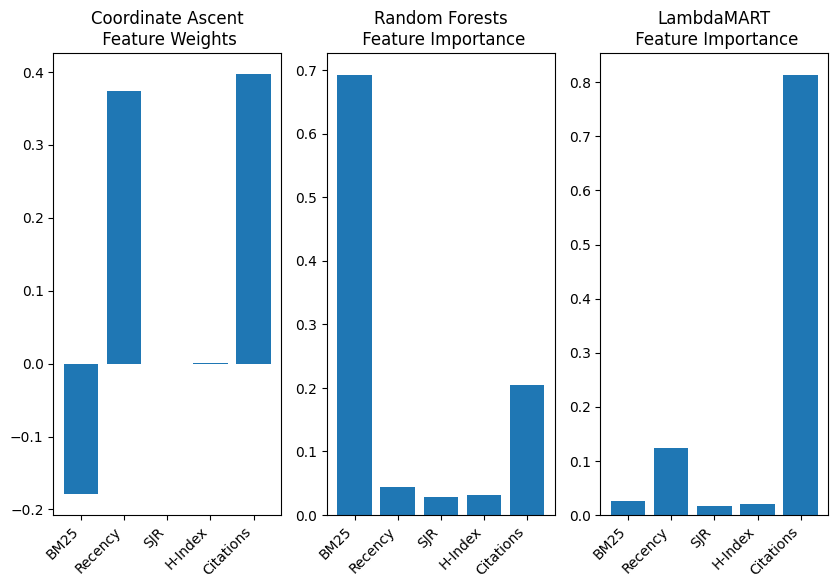

In [64]:
import matplotlib.pyplot as plt, numpy as np

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 6))

ax0.bar(np.arange(len(fnames)), ca_pipe[1].model.to_dict()['Linear']['weights'])
ax0.set_xticks(np.arange(len(fnames)))
ax0.set_xticklabels(fnames, rotation=45, ha='right')
ax0.set_title("Coordinate Ascent\n Feature Weights")

ax1.bar(np.arange(len(fnames)), rf.feature_importances_)
ax1.set_xticks(np.arange(len(fnames)))
ax1.set_xticklabels(fnames, rotation=45, ha='right')
ax1.set_title("Random Forests\n Feature Importance")

ax2.bar(np.arange(len(fnames)), lmart_x.feature_importances_)
ax2.set_xticks(np.arange(len(fnames)))
ax2.set_xticklabels(fnames, rotation=45, ha='right')
ax2.set_title("LambdaMART\n Feature Importance")

fig.show()


# Final results summary:

In [65]:
def train_models():
    fbr = pt.FeaturesBatchRetrieve(index, controls = {"wmodel": "BM25"}, features=["WMODEL:BM25"]) 
    fbr >> pt.apply.doc_features(_features)

    lmart_x_pipe = fbr >> pt.apply.doc_features(_features) >> pt.ltr.apply_learned_model(lmart_x, form="ltr")
    lmart_x_pipe.fit(train_topics, train_qrels, validation_topics, validation_qrels)

    rf_pipe = fbr >> pt.apply.doc_features(_features) >> pt.ltr.apply_learned_model(rf)
    rf_pipe.fit(train_topics, qrels)

    ca_pipe = fbr >> pt.apply.doc_features(_features) >> pt.ltr.apply_learned_model(train_request, form="fastrank")
    ca_pipe.fit(train_topics, qrels)

    fr_rf_pipe = fbr >> pt.apply.doc_features(_features) >> pt.ltr.apply_learned_model(train_request_forest, form="fastrank")
    fr_rf_pipe.fit(train_topics, qrels)

    results = pt.Experiment([PL2, BM25, lmart_x_pipe, rf_pipe, ca_pipe, fr_rf_pipe], test_topics, qrels, ["ndcg", "map"], 
                        names=["PL2 (Baseline)", "BM25 (base ranker)", "LambdaMART", "Random Forest", "Fastrank Coordinate Ascend", "Fastrank Random Forest"], baseline = 0, filter_by_topics = True)
    return(results)

# Results using the recency ranking

In [66]:
def _features(row):
    f1 = dates(row["docno"])
    f2 = sjr(row["docno"])
    f3 = h_idx(row["docno"])
    f4 = cites(row["docno"])
    features = np.append(row['features'], np.array([f1]))
    return features

In [67]:
results = train_models()
results

[21:32:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #2/5...
[+] Random restart #4/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   4|Feature         |   Weight|     NDCG
------------------------------

,name,map,ndcg,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value
0,PL2 (Baseline),0.313517,0.523699,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25 (base ranker),0.307945,0.527753,7.0,3.0,0.551904,6.0,4.0,0.461508
2,LambdaMART,0.235671,0.480390,3.0,7.0,0.038799,2.0,8.0,0.040872
3,Random Forest,0.175773,0.446467,0.0,10.0,0.006830,1.0,9.0,0.012435
4,Fastrank Coordinate Ascend,0.321934,0.539068,5.0,5.0,0.456311,6.0,4.0,0.068947
5,Fastrank Random Forest,0.197146,0.451229,0.0,10.0,0.001746,1.0,9.0,0.001036


# Results using the recency ranking and citation ranking

In [68]:
def _features(row):
    f1 = dates(row["docno"])
    f2 = sjr(row["docno"])
    f3 = h_idx(row["docno"])
    f4 = cites(row["docno"])
    features = np.append(row['features'], np.array([f1, f4]))
    return features

In [69]:
results = train_models()
results

[21:35:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #2/5...
[+] Random restart #4/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
------------------------------

,name,map,ndcg,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value
0,PL2 (Baseline),0.313517,0.523699,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25 (base ranker),0.307945,0.527753,7.0,3.0,0.551904,6.0,4.0,0.461508
2,LambdaMART,0.319983,0.522198,5.0,5.0,0.819442,5.0,5.0,0.924937
3,Random Forest,0.267476,0.497694,3.0,7.0,0.063665,2.0,8.0,0.081971
4,Fastrank Coordinate Ascend,0.324490,0.533865,5.0,5.0,0.609857,6.0,4.0,0.445300
5,Fastrank Random Forest,0.241822,0.472612,2.0,8.0,0.082096,2.0,8.0,0.039419


# Results using the journal ranking and citations ranking:

In [70]:
def _features(row):
    f1 = dates(row["docno"])
    f2 = sjr(row["docno"])
    f3 = h_idx(row["docno"])
    f4 = cites(row["docno"])
    features = np.append(row['features'], np.array([f2, f3, f4]))
    return features

In [71]:
results = train_models()
results

[21:39:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #2/5...
[+] Random restart #4/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   4|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
------------------------------

# Results using all features:

In [ ]:
def _features(row):
    f1 = dates(row["docno"])
    f2 = sjr(row["docno"])
    f3 = h_idx(row["docno"])
    f4 = cites(row["docno"])
    features = np.append(row['features'], np.array([f1, f2, f3, f4]))
    return features

In [ ]:
results = train_models()
results

[20:57:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #2/5...
[+] Random restart #3/5...
[+] Random restart #4/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
------------------------------

,name,map,ndcg,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value
0,PL2 (Baseline),0.313517,0.523699,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25 (base ranker),0.307945,0.527753,7.0,3.0,0.551904,6.0,4.0,0.461508
2,LambdaMART,0.309922,0.518697,5.0,5.0,0.888364,4.0,6.0,0.683880
3,Random Forest,0.263453,0.498686,3.0,7.0,0.064862,2.0,8.0,0.091067
4,Fastrank Coordinate Ascend,0.323972,0.533709,5.0,5.0,0.629938,6.0,4.0,0.455064
5,Fastrank Random Forest,0.253146,0.478363,4.0,6.0,0.195418,4.0,6.0,0.069068


# Results using only the citation ranking:

In [ ]:
def _features(row):
    f1 = dates(row["docno"])
    f2 = sjr(row["docno"])
    f3 = h_idx(row["docno"])
    f4 = cites(row["docno"])
    features = np.append(row['features'], np.array([f4]))
    return features

In [ ]:
results = train_models()
results

[21:00:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "verbose" } are not used.



KeyboardInterrupt: 

# Using Journal rankings only

In [ ]:
def _features(row):
    f1 = dates(row["docno"])
    f2 = sjr(row["docno"])
    f3 = h_idx(row["docno"])
    f4 = cites(row["docno"])
    features = np.append(row['features'], np.array([f2, f3]))
    return features

In [ ]:
results = train_models()
results

[13:40:40] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "num_round", "verbose" } are not used.

---------------------------
Training starts...
---------------------------
[+] Random restart #1/5...
[+] Random restart #3/5...
[+] Random restart #2/5...
[+] Random restart #4/5...
[+] Random restart #5/5...
Shuffle features and optimize!
----------------------------------------
   0|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   3|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   1|Feature         |   Weight|     NDCG
----------------------------------------
Shuffle features and optimize!
----------------------------------------
   2|Feature         |   Weight|     NDCG
-----------------

,name,map,ndcg,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value
0,PL2 (Baseline),0.313517,0.523699,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25 (base ranker),0.307945,0.527753,7.0,3.0,0.551904,6.0,4.0,0.461508
2,LambdaMART,0.166378,0.436964,0.0,10.0,0.005058,1.0,9.0,0.004475
3,Random Forest,0.156414,0.429865,0.0,10.0,0.003596,1.0,9.0,0.003858
4,Fastrank Coordinate Ascend,0.281949,0.514405,1.0,9.0,0.032475,2.0,8.0,0.243208
5,Fastrank Random Forest,0.159306,0.425142,0.0,10.0,0.003086,1.0,9.0,0.002276


# Creating a Knowledge Graph out of topic 1: Coronavirus Origin

In [ ]:
df = pd.DataFrame(qrels)

In [ ]:
df = df[df['qid'] == '1']
merged = pd.merge(df, metadata, how = 'left', left_on = 'docno', right_on='cord_uid')
merged = merged[['title', 'source_x']]

In [ ]:
topic_df = pd.DataFrame()
#for i in range(0, len(merged)):
    try:
        title_information = requests.get(
           'https://api.openalex.org/works?filter=title.search:'+merged['title'][i]
            ).json()['results'][0]
        current_title = pd.DataFrame.from_dict(title_information, orient='index')
        current_title = current_title.transpose()
        topic_df = topic_df.append(current_title)
        print(i)
    except:
        print("No title found")

IndentationError: unexpected indent (1801799540.py, line 3)

In [ ]:
topic_df = topic_df[['title', 'publication_year', 'concepts']]
for i in range(len(topic_df)):
    try:
        topic_df.iloc[i, topic_df.columns.get_loc('concepts')] = topic_df.iloc[i]['concepts'][0]['display_name']
    except:
        topic_df.iloc[i, topic_df.columns.get_loc('concepts')] = "Unknown"

/Users/nicolasrehbach/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/nicolasrehbach/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [ ]:
topic_df = topic_df.reset_index(drop=True)


In [ ]:
topic_df = topic_df.reset_index(drop=True)
topic_df.to_csv(r'../WIR-Project/data/graph.csv', index=False, header=True) 